In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import scikitplot as skplt

### Modelos de classificação

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC


### Métricas

In [20]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

## Importando o Dataset

O dataset foi tirado do Kaggle, pelo link https://www.kaggle.com/rashikrahmanpritom/heart-attack-analysis-prediction-dataset. O dataset consiste em um conjunto de dados sobre a saúde de pacientes, de tal forma que a variável target, a qual devemos fazer a predição, é a chance de ter um ataque cardíaco, de 0 a 1, de um paciente baseado nos seguintes atributos:
1. Idade
2. Sexo
3. Angina induzida por exercícios
4. Número de grandes vasos sanguíneos
5. Tipo de dor no peito
6. Pressão sanguínea em repouso
7. Colesterol
8. Açúcar no sangue em jejum
9. Resultado do ECG
10. Maior valor do batimento cardíaco

In [21]:
heart_df = pd.read_csv('HeartAttack/heart.csv')

In [22]:
heart_df

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


## Separação em Dados de Treino e Dados de Teste

### Checando se os dados estão balanceados

In [23]:
heart_df['output'].value_counts()

1    165
0    138
Name: output, dtype: int64

### Dividindo os dados em treino e teste

In [24]:
X = heart_df.drop(columns=['output'])
y = heart_df['output']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## GridSearch para Estimar Hiperparâmetros

In [25]:
def best_estimator(cls, params, cv=10):
    pipe = Pipeline(steps=[('scale', StandardScaler()), ('cls', cls)])
    gs = GridSearchCV(estimator=pipe, 
                  param_grid=params,
                  cv=cv,
                  n_jobs=-1)
    
    gs.fit(X_train, y_train)
    return gs

### Valores para hiperparâmetros

In [26]:
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
lr_param = {
            'cls__fit_intercept' : [True, False],
            'cls__solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
            'cls__C' : param_range
}

svc_param = {
            'cls__C' : param_range,
            'cls__kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
            'cls__degree': [_ for _ in range (3, 8)],
            'cls__decision_function_shape' : ['ovo', 'ovr']
}

gnb_param = {
            'cls__var_smoothing' : [10**-9]
}

knn_param = {
            'cls__n_neighbors' : [_ for _ in range(2,16)],
            'cls__weights' : ['uniform', 'distance'],
            'cls__algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute']
}

rf_param = {
            'cls__n_estimators' : [_ for _ in range(5, 20, 5)],
            'cls__criterion' : ['gini', 'entropy'],
            'cls__max_depth' : [_ for _ in range(2, 16, 2)],
            'cls__min_samples_split' : [_ for _ in range(2,6)],
            'cls__min_samples_leaf' : [_ for _ in range(1, 5)],
            'cls__max_features' : ['auto', 'sqrt', 'log2']
}



### Modelos

In [27]:
models = [(LogisticRegression(), lr_param), (SVC(), svc_param), (GaussianNB(), gnb_param), (KNeighborsClassifier(), knn_param), (RandomForestClassifier(), rf_param)]

In [28]:
models_gs = []

for model in models:
    print(model[0])
    pipe = model[0]
    params = model[1]
    models_gs.append(best_estimator(pipe, params))

LogisticRegression()
SVC()
GaussianNB()
KNeighborsClassifier()
RandomForestClassifier()


## Classificadores

### Regressão Logística

#### Melhores Hiperparâmetros

In [29]:
models_gs[0].best_params_

{'cls__C': 0.1, 'cls__fit_intercept': False, 'cls__solver': 'newton-cg'}

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

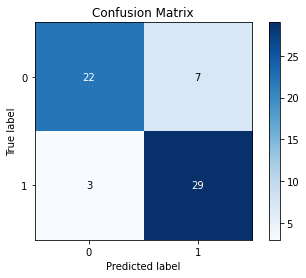

In [48]:
lr = models_gs[0]
lr.best_estimator_.fit(X_train, y_train)
lr_pred = lr.best_estimator_.predict(X_test)

skplt.metrics.plot_confusion_matrix(y_test, lr_pred)

### Support Vector Machines - SVC

O SVM recebe de entrada um conjunto de dados que fazem parte de duas classes e procura procurar o melhor hiperplano que as divide. Inicialmente, se não for possível traçar uma linha que separa as classes decentemente, uma nova dimensão é inserida no problema e o hiperplano é traçado. Posteriormente, o algoritmo retorna à dimensão inicial com as classes devidamente separadas.

#### Melhores Hiperparâmetros

In [ ]:
models_gs[1].best_params_

{'cls__C': 1.0,
 'cls__decision_function_shape': 'ovo',
 'cls__degree': 3,
 'cls__kernel': 'linear'}

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

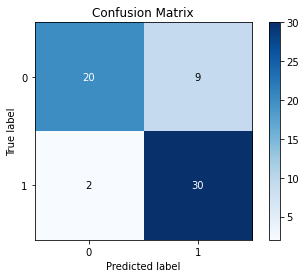

In [49]:
svc = models_gs[1]
svc.best_estimator_.fit(X_train, y_train)
svc_pred = svc.best_estimator_.predict(X_test)

skplt.metrics.plot_confusion_matrix(y_test, svc_pred)

### GaussianNB

O algoritmo Gaussian Naive Bayes é um classificador que utiliza as probabilidades dos eventos para gerar o modelo. É chamado de Naive (ingênuo) pois desconsidera as correlações entre as features, por exemplo, se o objetivo é classificar se um abacaxi é um abacaxi e as features são gosto (doce ou amargo), cor, possui_espinhos ..., o algoritmo trata as features de forma independente.

#### Melhores Hiperparâmetros

In [ ]:
models_gs[2].best_params_

{'cls__var_smoothing': 1e-09}

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

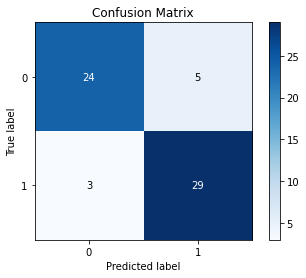

In [50]:
gnb = models_gs[2]
gnb.best_estimator_.fit(X_train, y_train)
gnb_pred = gnb.best_estimator_.predict(X_test)

skplt.metrics.plot_confusion_matrix(y_test, gnb_pred)

### KNN

#### Melhores Hiperparâmetros

In [ ]:
models_gs[3].best_params_

{'cls__algorithm': 'auto', 'cls__n_neighbors': 6, 'cls__weights': 'uniform'}

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

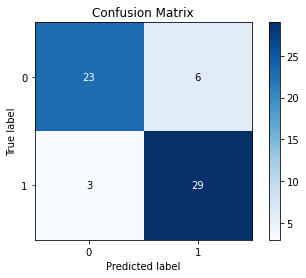

In [51]:
knn = models_gs[3]
knn.best_estimator_.fit(X_train, y_train)
knn_pred = knn.best_estimator_.predict(X_test)

skplt.metrics.plot_confusion_matrix(y_test, knn_pred)

### Random Forest

A Random Forest é um método Ensemble de árvores de decisão. Isso quer dizer que esse método é um agrupamento de modelos de árvores de decisão, com o objetivo de reduzir a variância dos resultados e tornar o modelo mais estável e preciso. 

Diferentes árvores de decisão são construídas a partir do mesmo conjunto de dados e, de forma aleatória, o modelo consulta cada árvore e o retorno do método é a média dos resultados de cada árvore de decisão, no caso da regressão.

A árvore de decisão é um método de aprendizagem de máquina supervisionado, em que se é criada uma árvore a partir da divisão do espaço amostral em várias subregiões, a fim de fazer uma decisão sobre o resultado final, no caso, a chance de o paciente sofrer um ataque cardíaco. A árvore procura o atributo que gera a melhor divisão dos dados, o conjunto de maior pureza, escolhido por meio de alguma métrica, como o erro médio quadrado ou erro médio absoluto.

Como vantagem, podemos citar que aceita tanto dados categóricos quanto numéricos, o que reduz a necessidade de tratamento dos dados. Porém, como desvantagem, podemos citar a propensão ao overfitting, logo temos que ter cuidado com isso.

#### Melhores Hiperparâmetros

In [35]:
models_gs[4].best_params_

{'cls__criterion': 'entropy',
 'cls__max_depth': 14,
 'cls__max_features': 'sqrt',
 'cls__min_samples_leaf': 3,
 'cls__min_samples_split': 2,
 'cls__n_estimators': 10}

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

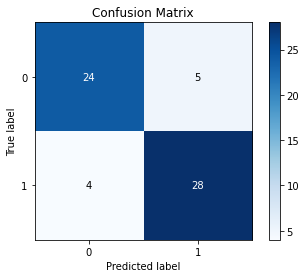

In [52]:
rf = models_gs[4]
rf.best_estimator_.fit(X_train, y_train)
rf_pred = rf.best_estimator_.predict(X_test)

skplt.metrics.plot_confusion_matrix(y_test, rf_pred)

## Resultados

In [54]:
metrics_df = pd.DataFrame(None)
estimators = ['Regressão Logística', 'SVC', 'Naive Bayes Gaussiano','KNN', 'Random Forest']
predictions = [lr_pred, knn_pred, svc_pred, rf_pred, gnb_pred]

i = 0
for pred in predictions_test:
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)

    row = pd.DataFrame(['Teste', estimators[i], accuracy, precision, recall, f1]).T
    metrics_df = pd.concat([metrics_df, row], ignore_index=True)
    i += 1

metrics_df.columns = ['Subconjunto', 'Modelo', 'Accuracy', 'Precision', 'Recall', 'F1-score']
metrics_df.set_index(['Modelo', 'Subconjunto'])

,,Accuracy,Precision,Recall,F1-score
Modelo,Subconjunto,,,,
Regressão Logística,Teste,0.836066,0.805556,0.90625,0.852941
SVC,Teste,0.852459,0.828571,0.90625,0.865672
Naive Bayes Gaussiano,Teste,0.819672,0.769231,0.9375,0.84507
KNN,Teste,0.852459,0.810811,0.9375,0.869565
Random Forest,Teste,0.868852,0.852941,0.90625,0.878788


## Conclusão